In [1]:
from builtins import range

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.datasets import load_wine, load_digits
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler

In [2]:
plt.style.use('seaborn-darkgrid')

In [3]:
def plot_scatter(x, y, auto_scaled=True, title=None, clusters=None):
    plt.figure(figsize=(4, 4))
    plt.scatter(x, y, c=clusters, cmap='plasma_r')

    if not auto_scaled:
        plt.axis('square')

    plt.grid(True)
    plt.title(title)

    plt.show()


def return_X_y(data, target_column):
    return data.drop(target_column, axis=1), data[target_column]

In [4]:
wine_sklearn = load_wine(as_frame=True)
wine_data, wine_labels = wine_sklearn['data'], wine_sklearn['target']
wine_data.head()

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline
0,14.23,1.71,2.43,15.6,127.0,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065.0
1,13.20,1.78,2.14,11.2,100.0,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050.0
2,13.16,2.36,2.67,18.6,101.0,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185.0
3,14.37,1.95,2.50,16.8,113.0,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480.0
4,13.24,2.59,2.87,21.0,118.0,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735.0


# Homework

## Exercise  1 - Scaling (2 points)

Perform standardization for wine dataset (`wine_data`) using only basic python, numpy and pandas (without using `StandardScaler` and sklearn at all). Implementation of function (or class) that can get dataset as input and return standardized dataset as output is preferrable, but not necessary.

Compare you results (output) with `StandardScaler`.

**NOTE:**

- 1 point for functional version, 2 points for implementing scaling as sklearn pipeline compartible class. 
- Maximum for the exercise is 2 points.


### Simple version (1 point)

In [5]:
import math


# 1 point
def scale(X):
    table = pd.DataFrame({})
    for feature in X:
        col = np.array(X[feature])
        mean = np.sum(col) / (len(col))
        deviation = math.sqrt(np.sum((col - mean) ** 2) / len(col))
        table[feature] = pd.Series((col - mean) / deviation)
    table.columns = np.array(X.columns)
    return table

In [6]:
assert np.allclose(np.array(scale(wine_data)), StandardScaler().fit_transform(wine_data))
'success'

'success'

### Pipeline Version (2 points)

In [7]:
# 2 points
from sklearn.base import BaseEstimator, TransformerMixin


class CustomScaler(BaseEstimator, TransformerMixin):
    def __init__(self, copy=True, with_mean=True, with_std=True):
        self.copy_ = copy
        self.with_mean_ = with_mean
        self.with_std_ = with_std
        self.mean_ = np.empty(0)
        self.std_ = np.empty(0)

    def fit(self, X, y=None):
        for feature in X:
            col = np.array(X[feature])
            mean = np.sum(col) / len(col)
            self.mean_ = np.append(self.mean_, mean)
            deviation = math.sqrt(np.sum((col - mean) ** 2) / len(col))
            self.std_ = np.append(self.std_, deviation)
        return self

    def transform(self, X, y=None, copy=None):
        if not self.copy_:
            table = X
        else:
            table = pd.DataFrame({})
        for i in range(X.shape[1]):
            feature = X.columns[i]
            col = np.array(X[feature])
            if self.with_mean_:
                col = col - self.mean_[i]
            if self.with_std_:
                col = col / self.std_[i]
            table[feature] = col
        return table

In [8]:
assert np.allclose(CustomScaler().fit_transform(wine_data), StandardScaler().fit_transform(wine_data))
'success'
#table

'success'

## Exercise  2 - Visualization (3 points)

As noted earlier, standardization/normalization of data can be crucial for some distance-based ML methods.

Let’s generate some toy example of unnormalized data and visualize the importance of this process once more:

In [9]:
feature_0 = np.random.randn(1000) * 10
feature_1 = np.concatenate([np.random.randn(500), np.random.randn(500) + 5])
data = np.column_stack([feature_0, feature_1])
#data

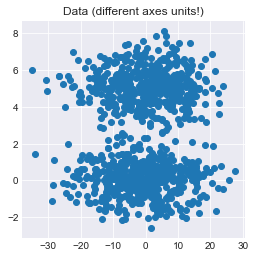

In [10]:
plot_scatter(data[:, 0], data[:, 1], auto_scaled=True, title='Data (different axes units!)')

**NOTE:** on the plot above axes are scaled differently and we can clearly see two potential *classes/clusters*. In fact `matplotlib` performed `autoscaling` (which is basically can be considered as `MinMaxScaling` of original data) just for better visualization purposes.

Let's turn this feature off and visualize the original data on the plot with equally scaled axes:

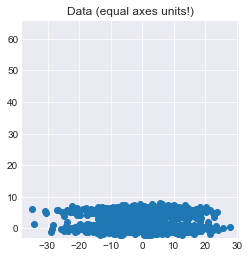

In [11]:
plot_scatter(data[:, 0], data[:, 1], auto_scaled=False, title='Data (equal axes units!)')

This picture is clearly less interpretable, but much closer to "how distance-based algorithm see the original data": separability of data is hardly noticable only because the variation (std) of x-feature is much bigger in absolute numbers.

Perform `StandardScaling` and `MinMaxScaling` of original data; visualize results for each case (**use `plot_scatter` with `auto_scaled=False`**):

### MinMaxScaling (0.5 point)

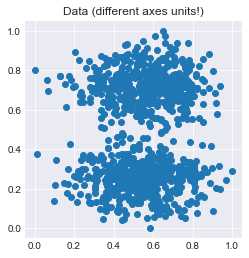

In [12]:
## your code
df = MinMaxScaler().fit_transform(data)
plot_scatter(df[:, 0], df[:, 1], auto_scaled=False, title='Data (different axes units!)')

### StandardScaler (0.5 point)

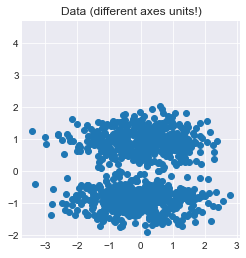

In [13]:
## your code
df = StandardScaler().fit_transform(data)
plot_scatter(df[:, 0], df[:, 1], auto_scaled=False, title='Data (different axes units!)')

### (Bonus) K-means (2 points)

Illustrate the impact of scaling on basic distance-based clustering algorithm [K-means](https://towardsdatascience.com/understanding-k-means-clustering-in-machine-learning-6a6e67336aa1) using `data` generated above.

**NOTE:** basically, you don't need understanding K-means algorithm here, you just need to:

1) run algorithm (with k=2, k - number of clusters/classes) on unscaled data    
2) run algorithm (with k=2) on scaled data    
3) plot results: highlight different clusters using different colors.

You can use this [question](https://stats.stackexchange.com/questions/89809/is-it-important-to-scale-data-before-clustering/89813) as a hint, but I recommend you to plot results using `plot_scatter` with `equal_scaled=True`: it might help you to intuitively understand the reasons of such scaling impact.


centroids: 
 [[ 6.89840553  2.74553849]
 [-9.32272141  2.37335655]]


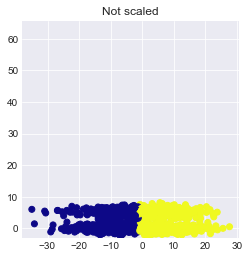

In [14]:
## your code
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=2)
results = kmeans.fit(data)
print('centroids: \n', results.cluster_centers_)
labels = kmeans.predict(data)
plot_scatter(data[:, 0], data[:, 1], False, 'Not scaled', labels)

centroids: 
 [[0.53876449 0.2466665 ]
 [0.56246864 0.71902299]]


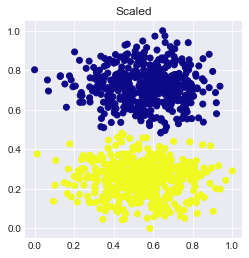

In [15]:
df = MinMaxScaler().fit_transform(data)

kmeans = KMeans(n_clusters=2)
results = kmeans.fit(df)
print('centroids: \n', results.cluster_centers_)
labels = kmeans.predict(df)
plot_scatter(df[:, 0], df[:, 1], False, 'Scaled', labels)

As we can see if data is not scaled then the algorithm K-means can find incorrect centroids. Performance of K-means depend on whether data is scaled or not

## Exercise  3 - Preprocessing Pipeline (2 points)

In [16]:
wine_sklearn = load_wine(as_frame=True)
wine_data, wine_labels = wine_sklearn['data'], wine_sklearn['target']
# print(wine_data.head())

wine_data, wine_labels = wine_sklearn['data'], wine_sklearn['target']
wine_train, wine_val, wine_labels_train, wine_labels_val = train_test_split(wine_data, wine_labels,
                                                                            test_size=0.3, random_state=42)

Train model (for example, `LogisticRegression(solver='liblinear', penalty='l1')` on raw `wine_train` data; then train same model after data scaling; then add feature selection (and train model again on scaled data). For each experiment all required preprocessing steps (if any) should be wrapped into sklearn pipeline.

Measure `accuracy` of all 3 approaches on `wine_val` dataset. Describe and explain results.

In [17]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LassoCV
from sklearn.feature_selection import VarianceThreshold, SelectKBest, chi2, SequentialFeatureSelector
from sklearn import metrics


def make_model(with_scaling, with_feature_selection):
    regressor = LogisticRegression(solver='liblinear', penalty='l1')
    sfm = SelectFromModel(LassoCV(), threshold=0.0)
    #selector = SelectKBest(score_func=chi2,k=6)
    vt = VarianceThreshold(threshold=0.0)
    sfs = SequentialFeatureSelector(KNeighborsClassifier(n_neighbors=5), n_features_to_select=12)
    scaler = MinMaxScaler() #StandardScaler()
    if with_scaling and with_feature_selection:
        return Pipeline([
            ('vt', vt),
            ('sfm', sfm),
            ('sfs', sfs),
            #('sel', selector),
            ('sca', scaler),
            ('reg', regressor)
        ])
    elif with_scaling and (not with_feature_selection):
        return Pipeline([
            ('sca', scaler),
            ('reg', regressor)
        ])
    elif (not with_scaling) and with_feature_selection:
        return Pipeline([
            ('vt', vt),
            ('sfm', sfm),
            ('sfs', sfs),
            ('reg', regressor)
        ])
    return Pipeline([
        ('reg', regressor)
    ])

from sklearn import set_config
set_config(display='diagram')
display(make_model(True, True))

def fit_evaluate(clf, X_train, y_train, X_test, y_test):
    clf.fit(X_train, y_train)
    return metrics.accuracy_score(y_pred=clf.predict(X_train), y_true=y_train),\
           metrics.accuracy_score(y_pred=clf.predict(X_test), y_true=y_test)


model = make_model(False, False)
train_acc, test_acc = fit_evaluate(model, wine_train, wine_labels_train, wine_val, wine_labels_val)
print('train accuracy and test accuracy for the case of unscaled data and without feature selection:', train_acc, test_acc)

model = make_model(True, False)
train_acc, test_acc = fit_evaluate(model, wine_train, wine_labels_train, wine_val, wine_labels_val)
print('\ntrain accuracy and test accuracy for the case of scaled data and without feature selection:', train_acc, test_acc)

model = make_model(True, True)
train_acc, test_acc = fit_evaluate(model, wine_train, wine_labels_train, wine_val, wine_labels_val)
print('\ntrain accuracy and test accuracy for the case of scaled data and with feature selection:', train_acc, test_acc)

train accuracy and test accuracy for the case of unscaled data and without feature selection: 0.967741935483871 0.9814814814814815

train accuracy and test accuracy for the case of scaled data and without feature selection: 0.967741935483871 1.0

train accuracy and test accuracy for the case of scaled data and with feature selection: 0.9596774193548387 0.9629629629629629


Logistic regression with the penalty `L1` had accuracy less for the unscaled data than for scaled. Accuracy of the model for the scaled data with feature selection is less than on the scaled data and without feature selection.

## Exercise 4 - manual PCA (5 points)
The task is to solve PCA as an optimization problem, without explicitly doing eigen value decomposition.
In the most general setting PCA is minimization of reconstruction error of a projection of given rank $q$

$$\min_{\mu, \lambda_1,\ldots, \lambda_n, \mathbf{V}_q} \sum_{i=1}^n ||x_i - \mu - \mathbf{V}_q \lambda_i||^2$$

With a number of steps that can be found here https://stats.stackexchange.com/a/10260 this task transforms to
 $$\max_{u_i} \sum_{i=1}^q u_i^T \mathbf{S} u_i$$
 where $\mathbf{S}$ is the sample covariance matrix (after standartization) and $u_1, \ldots, u_q$ are the $q$ are orthonormal columns in $\mathbf{V}_q$.
 Let us solve this optimization problem with `scipy.optimize` library.
 
 Additional 2 point are given for visualization of the results.

### PCA (3 points)

In [18]:
wine_data, wine_labels = wine_sklearn['data'], wine_sklearn['target']

Find a covariance matrix of standartized data and assing it to S.

In [19]:
data = StandardScaler().fit_transform(wine_data)
n, m = data.shape
S = np.empty([m, m])
for i in range(m):
    for j in range(m):
        mean_i = np.sum(data[:, i]) / (n - 1)
        mean_j = np.sum(data[:, j]) / (n - 1)
        S[i, j] = ((data[:, i] - mean_i) @ (data[:, j] - mean_j)) / (n - 1)
# S
#S = np.cov(data.T, ddof=1)
#S

If your code is correct, the following assert should be Ok.

In [20]:
assert np.allclose(np.linalg.norm(S), 5.787241159764733)
'success'

'success'

In [21]:
from scipy.optimize import minimize


# x - matrix m by m
def objective(x):
    return - x.T @ S @ x


# your code: write objective of the problem (don't forget that scipy does min while we need max)

def norm_constraint(x):
    return np.linalg.norm(x) - 1


# your code: constaraint norm of x to be 1, function should return 0 if constraint holds

con1 = {'type': 'eq', 'fun': norm_constraint}

#x0 = (1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)  # your code: initial vector to start optimization
x0 = np.zeros(m)
x0[0] = 1

sol = minimize(objective, x0, constraints=[con1])

x0 = sol.x
#x0

In [22]:
x0.T @ S @ x0

4.732437060485504

Hurray! We have the first vector! Let's do another one.

In [23]:
def orthogonality_constraint(x):
    return x0 @ x  #+ abs(norm_constraint(x))


# your code: x should be orthogonal to x0, function should return 0 if constraint holds

con2 = {'type': 'eq', 'fun': orthogonality_constraint}


x1 = np.array(
    [1 / x0[0], -1 / x0[1], 1 / x0[2], -1 / x0[3], 0, 1 / x0[5], 0, -1 / x0[7], 0, 1 / x0[9], -1 / x0[10], 1 / x0[11],
     -1 / x0[12]], dtype=np.float64)

a = np.linalg.norm(x1)
x1 = x1 / a

sol = minimize(objective, x1, constraints=[con1, con2])

x1 = sol.x
#x1

In [24]:
x1.T @ S @ x1

2.511080933586353

If your solution is correct, the following asserts should be Ok.

In [25]:
assert np.allclose(x0 @ S @ x0, 4.732436977583595)
assert np.allclose(x1 @ S @ x1, 2.5110809296451233)
'success'

'success'

### Visualization (2 points)

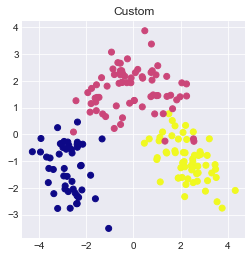

In [26]:
# custom dimension reduction with 2 components
x = []
y = []
for v in data:
    x.append(v @ x0)
    y.append(v @ x1)
plot_scatter(x, y,True, 'Custom',wine_labels)

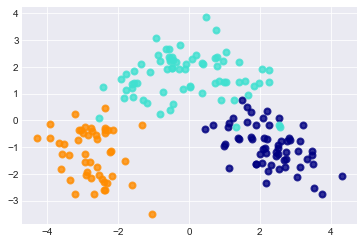

In [27]:
# Let's see how it looks by using PCA from sklearn
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_r = pca.fit(data).transform(data)

plt.figure()
colors = ["navy", "turquoise", "darkorange"]
lw = 2

for color, i, target_name in zip(colors, [0, 1, 2], np.unique(wine_labels)):
    plt.scatter(
        X_r[wine_labels == i, 0], X_r[wine_labels == i, 1], color=color, alpha=0.8, lw=lw, label=target_name
    )
#len(data)

Visualize the points after applying custom dimension reduction with 2 components.

## Exercise 5 - Boruta (3 points)

Let us classify handwritten digits 0, 1 and 2. 
To make task not so easy the images are binarized (no shadows of gray present) as it happens with xerocopied documents.

Let us also find out to which parts of an image there's no need to look in order to clasify three digits of interest.

In [28]:
X, y = load_digits(n_class=3, return_X_y=True, as_frame=True)
X = (X > 10).astype(int)

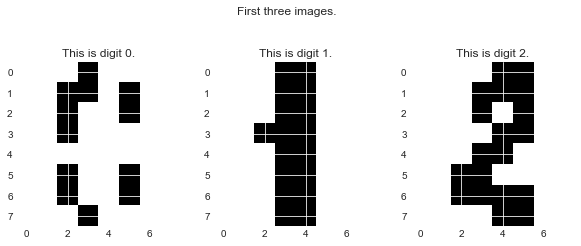

In [29]:
f, ax = plt.subplots(1, 3, figsize=(10, 4))
for i in range(3):
    ax[i].imshow(X.iloc[i].values.reshape(8, 8))
    ax[i].set_title(f"This is digit {y[i]}.")
plt.suptitle("First three images.")
plt.show()

Split data into train and test, let test size be 30% of the dataset and fix random state to 42:

In [30]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=42)

In [31]:
assert y_val.shape[0] == 162
assert y_val.sum() == 169
'success'

'success'

Fit a RandomForestClassifier with max_depth=13 and evaluate it's performance:

In [32]:
clf = RandomForestClassifier(max_depth=13)

train_acc, test_acc = fit_evaluate(clf, X_train, y_train, X_val, y_val)

acc = train_acc, test_acc  # your code here
print(acc)
acc = min(acc)
acc

(1.0, 0.9938271604938271)


0.9938271604938271

In [33]:
assert acc > 0.98
'success'

'success'

Now we will use Boruta to find redundand pixels. If the package is not installed in your system, uncomment and run the following cell.

In [34]:
! pip install boruta

In [35]:
from boruta import BorutaPy

feat_selector = BorutaPy(RandomForestClassifier(max_depth=13),
                         n_estimators='auto',
                         verbose=0,
                         max_iter=100,
                         random_state=42)

# your code here: do run the boruta
feat_selector.fit(np.array(X_train), np.array(y_train))

BorutaPy(estimator=RandomForestClassifier(max_depth=13, n_estimators=62,
                                          random_state=RandomState(MT19937) at 0x2A35636DA40),
         n_estimators='auto',
         random_state=RandomState(MT19937) at 0x2A35636DA40)

In [36]:
features = pd.DataFrame(X_train.columns.to_list(), columns=['features'])
features['rank'] = feat_selector.ranking_


Let us print redundant pixels as a mask. Does the result looks similar to mine (or to Among us chracters)? 

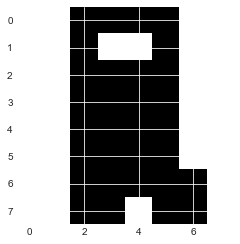

In [37]:
mask = np.array(feat_selector.support_).reshape(8, 8)
plt.imshow(mask);

At the end let us redo  classification but only with selected features

In [38]:
clf = RandomForestClassifier(max_depth=13)

selected_features = features[features['rank'] <= 6]['features']

train_acc, test_acc = fit_evaluate(clf, X_train[selected_features], y_train, X_val[selected_features], y_val)

acc = train_acc, test_acc  # your code here
acc = min(acc)
acc

0.9938271604938271

In [39]:
assert acc > 0.99

# Materials & References

1. General article about feature engineering and selection (main reference):
https://github.com/Yorko/mlcourse.ai/blob/master/jupyter_english/topic06_features_regression/topic6_feature_engineering_feature_selection.ipynb

2. Feature engineering/preprocessing, using scikit-learn API (great code examples, but really brief explanation):    
https://scikit-learn.org/stable/modules/preprocessing

3. Feature scaling/normalization:     
https://towardsdatascience.com/all-about-feature-scaling-bcc0ad75cb35

4. Log Transform/power transform:    
https://medium.com/@kyawsawhtoon/log-transformation-purpose-and-interpretation-9444b4b049c9

6. Missing values preprocessing using scikit-learn API (great code examples, great explanation):    
https://scikit-learn.org/stable/modules/impute.html

7. Feature selection scikit-learn API (great code examples, great explanation):   
https://scikit-learn.org/stable/modules/feature_selection.html

8. Melbourne housing dataset source:    
https://www.kaggle.com/anthonypino/melbourne-housing-market